In [ ]:
from cbio_py import cbio_mod as cb

studies = cb.getAllStudies()
print(f"Total number of studies: {len(studies)}")

# get the 5 study IDs with the most samples
sorted_samples = sorted(studies, key=lambda x: x['allSampleCount'], reverse=True)
print("Top 5 studies with the most samples:")
for studies in sorted_samples[:5]:
    print(f"Study ID: {studies['studyId']}, Sample Count: {studies['allSampleCount']}, Cancer Type: {studies['cancerTypeId']}")
    
print("Overall sample count across all studies:", sum(int(study['allSampleCount']) for study in sorted_samples[:5]))

Total number of studies: 483
Top 5 studies with the most samples:


TypeError: string indices must be integers, not 'str'

In [3]:
col_studies = []
count = 0
for study in sorted_samples:
    if study['cancerTypeId'] in ['coad', 'read', 'coadread']:
        print(f"Study ID: {study['studyId']}, Sample Count: {study['allSampleCount']}, Cancer Type: {study['cancerTypeId']}")
        count += 1
        col_studies.append(study)
        
print(f"Total number of studies with 'coad', 'read', or 'coadread' cancer types: {count}")
print(f"Total sample count for these studies: {sum(int(study['allSampleCount']) for study in col_studies)}")

Study ID: crc_msk_2017, Sample Count: 1134, Cancer Type: coadread
Study ID: coadread_tcga, Sample Count: 640, Cancer Type: coadread
Study ID: coadread_dfci_2016, Sample Count: 619, Cancer Type: coadread
Study ID: coadread_tcga_pan_can_atlas_2018, Sample Count: 594, Cancer Type: coadread
Study ID: crc_apc_impact_2020, Sample Count: 471, Cancer Type: coadread
Study ID: coad_tcga_gdc, Sample Count: 463, Cancer Type: coad
Study ID: coad_silu_2022, Sample Count: 348, Cancer Type: coad
Study ID: rectal_msk_2019, Sample Count: 339, Cancer Type: coadread
Study ID: coadread_tcga_pub, Sample Count: 276, Cancer Type: coadread
Study ID: read_tcga_gdc, Sample Count: 171, Cancer Type: read
Study ID: coadread_cass_2020, Sample Count: 146, Cancer Type: coadread
Study ID: coadread_mskcc, Sample Count: 138, Cancer Type: coadread
Study ID: coad_cptac_2019, Sample Count: 110, Cancer Type: coad
Study ID: coad_cptac_gdc, Sample Count: 109, Cancer Type: coad
Study ID: coadread_genentech, Sample Count: 74, Ca

In [4]:
from bravado.client import SwaggerClient
cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/v2/api-docs',
                                config={"validate_requests":False,"validate_responses":False,"validate_swagger_spec":False})

gene_mut = []
total_mutations = 0

for study in sorted_samples[:5]:
    # get the mutations for the first sample in each of the top 5 studies
    sample_list = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
        molecularProfileId=f"{study['studyId']}_mutations",
        sampleListId=f"{study['studyId']}_all"
    ).result()
    print(len(sample_list), "mutations found for study:", study['studyId'])
    total_mutations += len(sample_list)
    gene_mut.extend(sample_list)
    
# for study in col_studies:
#     # get the mutations for the first sample in each of the 'coad', 'read', or 'coadread' studies
#     sample_list = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
#         molecularProfileId=f"{study['studyId']}_mutations",
#         sampleListId=f"{study['studyId']}_all"
#     ).result()
#     print(len(sample_list), "mutations found for study:", study['studyId'])
#     total_mutations += len(sample_list)
#     gene_mut.extend(sample_list)
    
print("Total mutations considered:", total_mutations)

21517 mutations found for study: msk_ch_2023
227931 mutations found for study: msk_met_2021
208214 mutations found for study: msk_chord_2024
9813 mutations found for study: msk_ch_2020
78142 mutations found for study: msk_impact_2017
Total mutations considered: 545617


In [5]:
gene_list = cb.getAllGenes(return_type = 'dict')
gene_dict = {gene['entrezGeneId']: gene for gene in gene_list}

In [6]:
# output the mutations to a file
gene_set = set()
with open('../data/top_5_study_mutations.txt', 'w') as f:
    for mutation in gene_mut:
        if not mutation.entrezGeneId:
            print(mutation)
        gene = gene_dict[mutation.entrezGeneId]['hugoGeneSymbol']
        sample_id = mutation.sampleId
        f.write(f"{gene}\t{sample_id}\n")
        gene_set.add(mutation.entrezGeneId)

# output the unique genes to a file
with open('../data/unique_genes_mutated.txt', 'w') as f:
    for gene in gene_set:
        f.write(f"{gene_dict[gene]['hugoGeneSymbol']}\n")

In [9]:
# create a dataframe of the mutations
import pandas as pd
mut_df = pd.read_csv('../data/top_5_study_mutations.txt', sep='\t', header=None, names=['Gene', 'Sample'])
mut_df

,Gene,Sample
0,PIK3CA,P-0000199-N01-IM3
1,PIK3CA,P-0017300-N01-IM6
2,SF3B1,P-0023170-N01-IM6
3,SF3B1,P-0030558-N01-IM6
4,SF3B1,P-0034137-N01-IM6
...,...,...
545612,IRF4,P-0012557-T01-IM5
545613,PTPRD,P-0012622-T01-IM5
545614,ATRX,P-0012622-T01-IM5
545615,TERT,P-0012622-T01-IM5


In [ ]:
gene_mut_dict = {}
for i in range(len(mut_df)):
    if mut_df.iloc[i]['Sample'] not in gene_mut_dict:
        gene_mut_dict[mut_df.iloc[i]['Sample']] = set()
    gene_mut_dict[mut_df.iloc[i]['Sample']].add(mut_df.iloc[i]['Gene'])
    
gene_mut_dict

{'P-0000199-N01-IM3': {'PIK3CA'},
 'P-0017300-N01-IM6': {'NUF2', 'PIK3CA', 'SLX4'},
 'P-0023170-N01-IM6': {'DNMT3A', 'SF3B1', 'SH2B3'},
 'P-0030558-N01-IM6': {'CREBBP', 'DNMT3A', 'SF3B1'},
 'P-0034137-N01-IM6': {'DNMT3A', 'SF3B1'},
 'P-0002984-N01-IM3': {'IDH1'},
 'P-0013309-N01-IM5': {'IDH1'},
 'P-0017038-N01-IM6': {'ASXL1', 'IDH1', 'MLH1'},
 'P-0021405-N01-IM6': {'IDH1'},
 'P-0031300-N01-IM6': {'IDH1'},
 'P-0037199-N01-IM6': {'IDH1'},
 'P-0059678-N01-IM7': {'IDH1', 'PLCG2', 'SRSF2', 'TET2'},
 'P-0059718-N01-IM7': {'CHEK2', 'DNMT3A', 'IDH1'},
 'P-0029603-N01-IM6': {'FBXW7'},
 'P-0013848-N01-IM5': {'DNMT3A', 'TP53'},
 'P-0001393-N01-IM3': {'TP53'},
 'P-0002296-N01-IM3': {'TET2', 'TP53'},
 'P-0024395-N01-IM6': {'DNMT3A', 'NBN', 'TP53'},
 'P-0027841-N01-IM6': {'PPM1D', 'TP53'},
 'P-0029178-N01-IM6': {'IGF2', 'SDHC', 'SF3B1', 'TERT'},
 'P-0031918-N03-IM6': {'SMARCB1', 'STK11'},
 'P-0006880-N01-IM5': {'ATM'},
 'P-0010636-N01-IM5': {'ATM', 'DNMT3A', 'PAK5', 'PPM1D', 'PTPRT'},
 'P-0015496-N0

In [12]:
# Extract unique genes and samples
samples = list(gene_mut_dict.keys())
genes = sorted(set(g for genes in gene_mut_dict.values() for g in genes))

# Create a DataFrame initialized with zeros
df = pd.DataFrame(0, index=samples, columns=genes)

# Populate the DataFrame
for sample, mutated_genes in gene_mut_dict.items():
    df.loc[sample, list(mutated_genes)] = 1

df

,ABL1,ABRAXAS1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALB,ALK,ALOX12B,...,WT1,WWTR1,XIAP,XPO1,XRCC2,YAP1,YES1,ZFHX3,ZNRF3,ZRSR2
P-0000199-N01-IM3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0017300-N01-IM6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0023170-N01-IM6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0030558-N01-IM6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0034137-N01-IM6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P-0012403-T01-IM5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0012423-T01-IM5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
P-0012434-T01-IM5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0012524-T01-IM5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


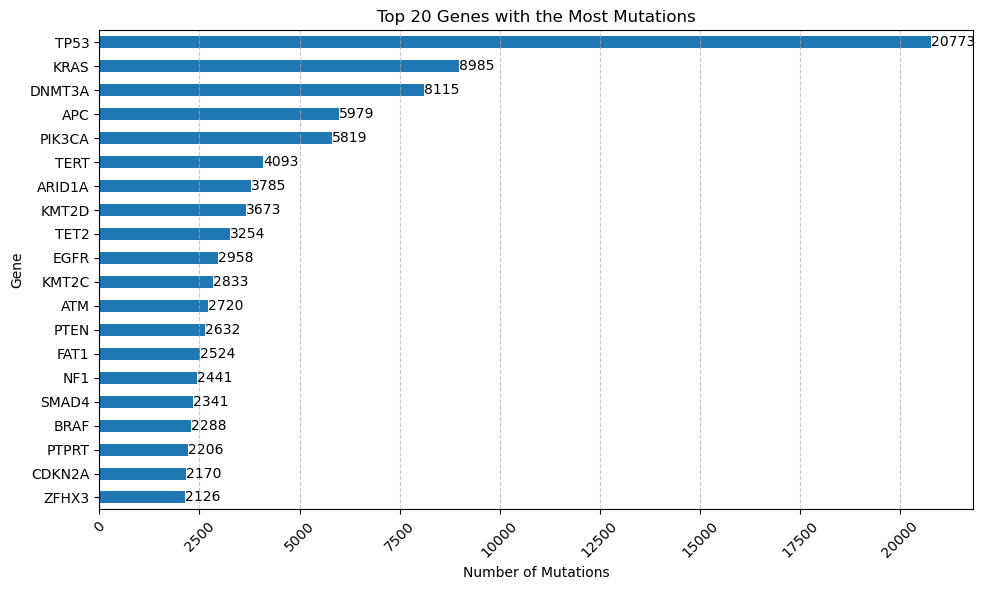

In [13]:
# data analysis
# top 20 genes with the most mutations
import matplotlib.pyplot as plt

top_genes = df.sum().sort_values(ascending=False).head(20)

# in the plot, we want to show the number of mutations for each gene
top_genes.plot(kind='barh', figsize=(10, 6))
plt.title('Top 20 Genes with the Most Mutations')
plt.xlabel('Number of Mutations')
# in each bar, we want to show the gene count/total samples
for index, value in enumerate(top_genes):
    plt.text(value, index, str(value), va='center')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()  # invert y axis to have the highest count on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlabel('Number of Mutations')
plt.ylabel('Gene')
plt.tight_layout()
plt.savefig('../data/top_20_genes_mutations.png')
plt.show()


In [14]:
# save df to a file
df.to_csv('../data/mutation_matrix.csv', index=True)

In [76]:
sample_cd = {}

for study in sorted_samples[:5]:
    print(f"Getting clinical data for study: {study['studyId']}")
    data = cb.getAllClinicalDataInStudy(studyId=study['studyId'])
    print(f"Number of clinical data samples in study {study['studyId']}: {len(data)}")
    
    for sample in data:
        if sample['sampleId'] not in sample_cd:
            sample_cd[sample['sampleId']] = []
            
        sample_cd[sample['sampleId']].append(sample)
        
    print(f"Total number of clinical data for now: {len(sample_cd)}")
        
# write the clinical data to a file
with open('../data/clinical_data.txt', 'w') as f:
    for sample, data in sample_cd.items():
        for d in data:
            f.write(f"{sample}\t{d['clinicalAttributeId']}\t{d['studyId']}\t{d['value']}\n")

Getting clinical data for study: msk_ch_2023
Number of clinical data samples in study msk_ch_2023: 140501
Total number of clinical data for now: 42714
Getting clinical data for study: msk_met_2021
Number of clinical data samples in study msk_met_2021: 1065484
Total number of clinical data for now: 68489
Getting clinical data for study: msk_chord_2024
Number of clinical data samples in study msk_chord_2024: 519147
Total number of clinical data for now: 81396
Getting clinical data for study: msk_ch_2020
Number of clinical data samples in study msk_ch_2020: 86085
Total number of clinical data for now: 105542
Getting clinical data for study: msk_impact_2017
Number of clinical data samples in study msk_impact_2017: 190340
Total number of clinical data for now: 108668


In [77]:
mutation_matrix = pd.read_csv('../data/mutation_matrix.csv')
for sampleid in mutation_matrix['Sample_ID'].values.tolist():
    if sampleid not in sample_cd:
        print(f"Sample ID {sampleid} not found in clinical data for the top 5 studies.")
        
# extend 2 columns to the mutation matrix: msi, stage, initialize with nan
mutation_matrix['MSI'] = float('nan')
mutation_matrix['Stage'] = float('nan')
mutation_matrix

,Sample_ID,ABL1,ABRAXAS1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALB,ALK,...,XIAP,XPO1,XRCC2,YAP1,YES1,ZFHX3,ZNRF3,ZRSR2,MSI,Stage
0,P-0000199-N01-IM3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,P-0017300-N01-IM6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,P-0023170-N01-IM6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,P-0030558-N01-IM6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,P-0034137-N01-IM6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58990,P-0012403-T01-IM5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
58991,P-0012423-T01-IM5,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,NaN,NaN
58992,P-0012434-T01-IM5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
58993,P-0012524-T01-IM5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN


In [80]:
total_case = len(mutation_matrix)
msi_count = 0
stage_count = 0

for id in mutation_matrix['Sample_ID'].values.tolist():
    for cd_data in sample_cd[id]:
        if cd_data['clinicalAttributeId'] == 'PATHOLOGICAL_GROUP' or cd_data['clinicalAttributeId'] == 'CLINICAL_STAGE':
            if cd_data['clinicalAttributeId'] == 'PATHOLOGICAL_GROUP':
            # for pathological group, we want to use the value as stage
                mutation_matrix.loc[mutation_matrix['Sample_ID'] == id, 'Stage'] = cd_data['value']
            elif cd_data['clinicalAttributeId'] == 'CLINICAL_STAGE':
                mutation_matrix.loc[mutation_matrix['Sample_ID'] == id, 'Stage'] = cd_data['value']
            stage_count += 1
            
        if cd_data['clinicalAttributeId'] == 'MSI_TYPE':
            mutation_matrix.loc[mutation_matrix['Sample_ID'] == id, 'MSI'] = cd_data['value']
            msi_count += 1

print(f"Total samples with stage data: {stage_count}/{total_case}")
print(f"Total samples with msi data: {msi_count}/{total_case}")
        
# # sampleId=P-0001534-T01-IM3&studyId=msk_chord_2024
# cb.getAllClinicalDataOfSampleInStudy(studyId='msk_chord_2024', sampleId='P-0001534-T01-IM3')

Total samples with stage data: 16909/58995
Total samples with msi data: 48227/58995


In [82]:
mutation_matrix.to_csv('../data/mutation_matrix_with_clinical_data.csv', index=False)